In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [5]:
data = pd.read_csv('data3a.csv')

In [8]:
data['f_int'] = (data.f == 'T').astype(int)

In [9]:
data.x_c = sm.add_constant(data.x)

In [19]:
#一定モデル
model1 = sm.GLM(data.y,data.x_c['const'],family=sm.families.Poisson())
result_1 = model1.fit()
#xモデル
model2 = sm.GLM(data.y,data.x_c,family=sm.families.Poisson())
result_2 = model2.fit()

逸脱度の差=尤度比

In [22]:
deltaD = -2*(result_1.llf - result_2.llf)
print deltaD

4.51394107885


一定モデルに比べてxモデルの逸脱度の差は4.5位となっており、これは一定モデルに比べてxモデルでは当てはまりの悪さである逸脱度が4.5改善されたということです。尤度検定では、検定統計量でああるこの逸脱度の差が「4.5ぐりでは改善されていない」と言って良いのかどうかを調べます。

- null hypothesis：一定モデル
- alternative hipothesis：xモデル

検定の流れ
- 帰無仮説である一定モデルが正しいものだと仮定する
- 観測データに一定モデルを当てはめると,β1＝2.06となったので、これは真のモデルとほぼ同じだと考えよう
- ｋの真のモデルからデータを何度も生成して、そのたびにβ2=0とβ2≠0のモデルを当てはめれば、たくさんの$\Delta D_{1,2}$が得られるから、$\Delta D_{1,2}$の分布がわかるだろう。
- そうすれば、一定モデルとxモデルの逸脱度の差が$\Delta D_{1,2} \geqq 4.5$となる確率Pが評価できる。

平均7.85のポアソン乱数を100個用意する

In [30]:
data['y_rand'] = np.random.poisson(data.y.mean(),100)
result_1 = sm.GLM(data.y_rand,data.x_c['const'],family=sm.families.Poisson()).fit()
result_2 = sm.GLM(data.y_rand,data.x_c,family=sm.families.Poisson()).fit()
deltaD = result_1.deviance - result_2.deviance
print deltaD

1.28171014051


このように、体サイズxとなんの関係もなし、平均値一定のポアソン乱数であるデータに対しても、逸脱度の差が1.28となりました。「真のモデル」である一定モデルよりも、無意味な説明変数をもつxモデルのほうが当てはまりが良くなります。
このようにして、「一定モデルが真のモデルある世界」での逸脱度の差がひとつ得られます。これはPB（パラメトリックブートストラップ法）の１スッテプであり、このステップを1000回ほど繰り返すと「検定統計量の分布」を予測できます。

In [42]:
def get_dd(data):
    data['y_rand'] = np.random.poisson(data.y.mean(),100)
    result = sm.GLM(data.y_rand,data.x_c,family=sm.families.Poisson()).fit()
    return result.null_deviance - result.deviance

def pb(data,n_bootstrap):
    return np.array([get_dd(data) for i in range(n_bootstrap)])

dd12 = pb(data,10000)

In [43]:
dd12 = pd.Series(dd12)
print dd12.describe()

count    1.000000e+04
mean     1.013135e+00
std      1.438992e+00
min      1.449507e-11
25%      1.003904e-01
50%      4.617117e-01
75%      1.319841e+00
max      1.857792e+01
dtype: float64


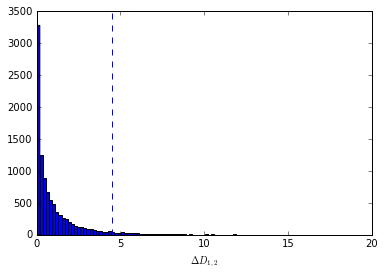

In [44]:
plt.hist(dd12,bins=100)
plt.xlabel('$\Delta D_{1,2}$')
plt.axvline(x=4.5,linestyle='--')
plt.show()

In [45]:
(dd12 >= 4.5).sum()

377

よって1000個中34個が4.5より大きいことがわかりました。つまり、P=0.034

P=0.05となる逸脱度の差をしらべると・・・

In [46]:
dd12.quantile(0.95)

3.9917186971909548